# Entrainement du GAN

In [1]:
import keras
from keras import layers
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from zipfile import ZipFile

import matplotlib.pyplot as plt

import random 

from PIL import Image
import os, os.path
from os import listdir
from os.path import isfile, join
import re
from PIL import Image as im

2023-02-13 10:01:03.159220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 10:01:03.867594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/atlas/anaconda3/envs/ml/lib/
2023-02-13 10:01:03.867677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/atlas/anaconda3/envs/ml/lib/
2023-02-13 10:01:03.867684: W tensorflow/compiler/tf2tenso

In [3]:
folder = 'src/img'
new_size = (64, 64)

for filename in os.listdir(folder):
    if filename.endswith('.jpeg'):
        filepath = os.path.join(folder, filename)
        with Image.open(filepath) as im:
            im = im.resize(new_size)
            im.save(filepath)

In [4]:
latent_dim = 64
height = 32
width = 32
channels = 3

In [5]:
dataset = keras.utils.image_dataset_from_directory(
    "src/img", 
    label_mode=None, image_size=(64,64),
     batch_size=32)

dataset = dataset.map(lambda x: x / 255.0)

Found 32436 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-13 10:02:42.529785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 10:02:42.989778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37803 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [6]:
#create discrminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64,64, 3)),
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        8208      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           2056      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)             

In [7]:
# create generator


generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 64),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 16)       16400     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       8224      
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0 

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save('model/generator.h5')
        self.model.discriminator.save('model/discriminator.h5')
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #genere un fichier random
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255 #pour mettre l'image en bon format
        generated_images.numpy() # converti les images keras en numpy
#        for i in range(self.num_img):
#            img = keras.preprocessing.image.array_to_img(generated_images[i])
#            img.save("generated_img_%03d_%d.png" % (epoch, i)) # enregistre l'image dans le chemin donné

In [10]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])
#on a pas beosin d'enregistrer le model mais uniquement les poids
# pourquoi les callbacks, -> 

Epoch 1/100


2023-02-13 10:03:50.171532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-13 10:03:50.327003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-13 10:03:51.106803: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-13 10:03:51.216056: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d5577f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-13 10:03:51.216077: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): A100-PCIE-40GB, Compute Capability 8.0
2023-02-13 10:03:51.221562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-13 10:03:51.294525: I tensorfl

1014/1014 [==============================] - 18s 13ms/step - d_loss: 0.6512 - g_loss: 0.8597
Epoch 2/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.6530 - g_loss: 0.9013
Epoch 3/100
1014/1014 [==============================] - 14s 14ms/step - d_loss: 0.6251 - g_loss: 0.9570
Epoch 4/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.6334 - g_loss: 0.9037
Epoch 5/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.7086 - g_loss: 0.8137
Epoch 6/100
1014/1014 [==============================] - 13s 12ms/step - d_loss: 0.6888 - g_loss: 0.8261
Epoch 7/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.6904 - g_loss: 0.8292
Epoch 8/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.6768 - g_loss: 0.8703
Epoch 9/100
1014/1014 [==============================] - 13s 13ms/step - d_loss: 0.6480 - g_loss: 0.9043
Epoch 10/100
1014/1014 [==============================] - 13s 13ms/

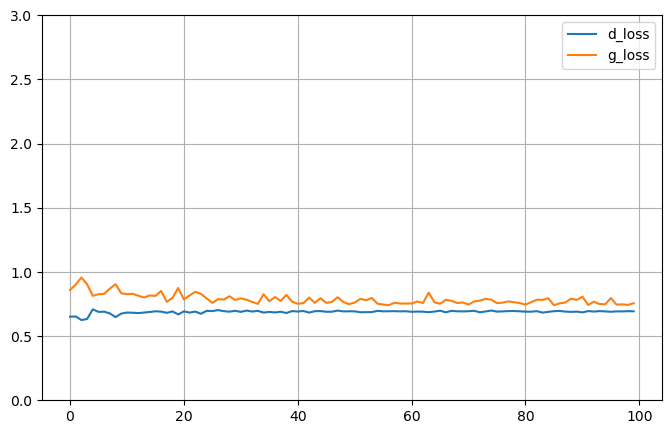

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-3]

plt.show()

In [12]:
model = tf.keras.models.load_model("model/generator.h5", custom_objects=None, compile=True, options=None)

In [13]:
model.compile()

In [14]:
batch_size = 20
latent_dim = 64
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = model.predict(random_latent_vectors)

1/1 [==============================] - 0s 141ms/step


In [15]:
batch_size = 20
latent_dim = 64
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

In [16]:
generated_images = model.predict(random_latent_vectors)

1/1 [==============================] - 0s 36ms/step


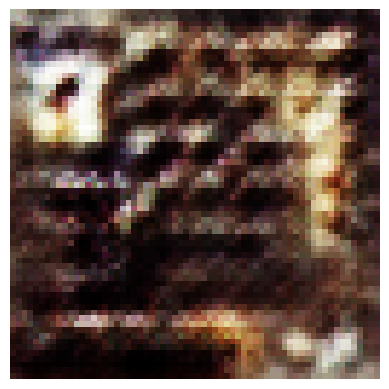

In [17]:
plt.axis("off")
plt.imshow((generated_images*255).astype("int32")[0])

In [18]:
from numba import cuda 

device = cuda.get_current_device()
device.reset()